# Getting Started with astropy.coordinates

## Authors
Erik Tollerud, Kelle Cruz, Stephen Pardy

## Learning Goals
- Create `astropy.coordinates.SkyCoord` objects using names and coordinates
- Interact with a `SkyCoord` object and access its attributes
- Use a `SkyCoord` object to query a database

## Keywords
coordinates, OOP


## Summary
In this tutorial, we're going to investigate the area of the sky around the picturesque group of galaxies named "Hickson Compact Group 7," download an image, and do something with its coordinates.

## Imports

In [1]:
# Python standard-library
from urllib.parse import urlencode
from urllib.request import urlretrieve

# Third-party dependencies
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
from IPython.display import Image

# Set up matplotlib and use a nicer set of plot parameters
from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
%matplotlib inline

## Describing on-sky locations with `coordinates`

The `SkyCoord` class in the `astropy.coordinates` package is used to represent celestial coordinates. First, we'll make a SkyCoord object based on our object's name, "Hickson Compact Group 7" or "HCG 7" for short. Most astronomical object names can be found by [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), a service which queries Simbad, NED, and VizieR and returns the object's type and its J2000 position. This service can be used via the `SkyCoord.from_name()` [class method](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods):

In [2]:
# initialize a SkyCood object named hcg7_center at the location of HCG 7
hcg7_center = SkyCoord.from_name('HCG 7')

<div class="alert alert-info">
Note that this requires an internet connection.  If you don't have one, execute this line instead:
</div>

In [3]:
# uncomment and run this line if you don't have an internet connection
# hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')

In [4]:
type(hcg7_center)

astropy.coordinates.sky_coordinate.SkyCoord

Show the available methods and attributes of the SkyCoord object we've created called `hcg7_center`

In [5]:
dir(hcg7_center)

['T',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_apply',
 '_extra_frameattr_names',
 '_parse_inputs',
 '_sky_coord_frame',
 'altaz',
 'apply_space_motion',
 'barycentrictrueecliptic',
 'cache',
 'cartesian',
 'cirs',
 'copy',
 'data',
 'dec',
 'default_differential',
 'default_representation',
 'diagonal',
 'differential_type',
 'distance',
 'equinox',
 'fk4',
 'fk4noeterms',
 'fk5',
 'flatten',
 'frame',
 'frame_attributes',
 'frame_specific_representation_info',
 'from_name',
 'fr

Show the RA and Dec.

In [6]:
print(hcg7_center.ra, hcg7_center.dec)
print(hcg7_center.ra.hour, hcg7_center.dec)

9d48m58.5s 0d53m17.016s
0.6544166666666668 0d53m17.016s


We see that, according to SESAME, HCG 7 is located at ra = 9.849 deg and dec = 0.878 deg. 

This object we've just created has various useful ways of accessing the information contained within it.  In particular, the ``ra`` and ``dec`` attributes are specialized [`Quantity`](http://docs.astropy.org/en/stable/units/index.html) objects (actually, a subclass called [`Angle`](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html), which in turn is subclassed by [`Latitude`](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html) and [`Longitude`](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)).  These objects store angles and provide pretty representations of those angles, as well as some useful attributes to quickly convert to common angle units:

In [7]:
type(hcg7_center.ra), type(hcg7_center.dec)

(astropy.coordinates.angles.Longitude, astropy.coordinates.angles.Latitude)

In [8]:
hcg7_center.ra, hcg7_center.dec

(<Longitude 9.81625 deg>, <Latitude 0.88806 deg>)

In [9]:
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

In [10]:
hcg7_center.ra.hour

0.6544166666666668

SkyCoord will also accept string-formatted coordinates either as separate strings for RA/Dec or a single string.  You'll need to give units, though, if they aren't part of the string itself.

In [11]:
SkyCoord('0h39m15.9s', '0d53m17.016s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

In [12]:
hcg7_center.ra.hour

0.6544166666666668

## Download an image
Now that we have a `SkyCoord` object, we can try to use it to access data from the [Sloan Digitial Sky Survey](http://www.sdss.org/) (SDSS).  Let's start by trying to get a picture using the SDSS image cutout service to make sure HCG 7 is in the SDSS footprint and has good image quality.

This requires an internet connection, but if it fails, don't worry: the file is included in the repository so you can just let it use the local file``'HCG7_SDSS_cutout.jpg'``, defined at the top of the cell.  

In [13]:
# tell the SDSS service how big of a cutout we want
im_size = 12*u.arcmin # get a 12 arcmin square
im_pixels = 1024 
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=hcg7_center.ra.deg, 
                              dec=hcg7_center.dec.deg, 
                              width=im_pixels, height=im_pixels, 
                              scale=im_size.to(u.arcsec).value/im_pixels))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'HCG7_SDSS_cutout.jpg')

('HCG7_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x7fe7c5267b38>)

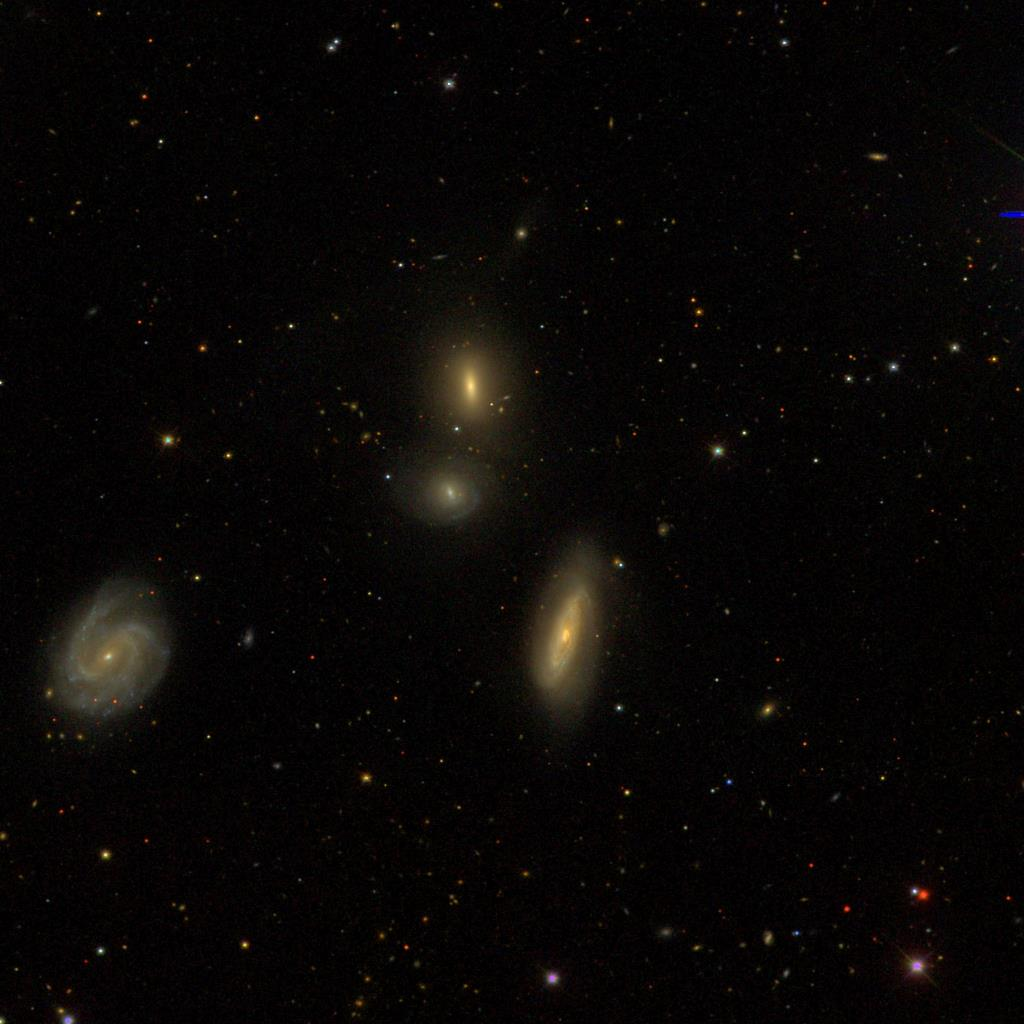

In [14]:
Image('HCG7_SDSS_cutout.jpg')

Very pretty!

## Exercises

### Excercise 1

Create a `SkyCoord` of some other astronomical object you find interesting. Using only a single method/function call, get a string with the RA/Dec in the form 'HH:MM:SS.S DD:MM:SS.S'.  Check your answer against an academic paper or a website like [SIMBAD](http://simbad.u-strasbg.fr/simbad/) that will show you sexigesimal coordinates for the object.

(Hint: `SkyCoord.to_string()` might be worth reading up on.)

### Excercise 2

Now get an image of that object from the Digitized Sky Survey and download it and/or show it in the notebook. Bonus points if you figure out the (one-line) trick to get it to display in the notebook *without* ever downloading the file yourself.

(Hint: STScI has an easy-to-access [copy of the DSS](https://archive.stsci.edu/dss/).  The pattern to follow for the web URL is ``http://archive.stsci.edu/cgi-bin/dss_search?f=GIF&ra=RA&dec=DEC``.)